In [4]:
#!/usr/bin/env python
# coding: utf-8
import warnings
warnings.filterwarnings("ignore")

import sys
import os
import datetime
import pickle
import io
import re
import code

from chainer import no_backprop_mode, cuda, Variable
from chainer.functions import relu
import cupy as cp
import numpy as np
import scipy.stats as stats
import statsmodels.stats.proportion as prop
from exp_settings import settings
import trainers.trainer as trainer
from measurements.robustness.utils import list_nets

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" # In case the GPU order in the bus is different from the one listed by CUDA


In [5]:
def change_gpu(model, gpu):
    """ Used in case the saved net was in a different GPU from the one used when loading
    Args:
        model: NNAgent object
        gpu: number of the GPU to be transfered to

    """
    for link in range(len(model)):
        if hasattr(model[link], 'W'):
            model[link].W.to_gpu(gpu)
            model[link].ortho_w.to_gpu(gpu)
            if hasattr(model[link], "kernel_size"):
                model[link].mask.to_gpu(gpu)
        if hasattr(model[link], 'b') and model[link].b is not None:
            model[link].b.to_gpu(gpu)

class RenameUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        renamed_module = module
        return super(RenameUnpickler, self).find_class(renamed_module, name)

class RenameUnpickler2(pickle.Unpickler):
    def find_class(self, module, name):
        renamed_module = module
        if module == "BNN_mod_bu":
            renamed_module = "BNN_mod_normal"
        return super(RenameUnpickler2, self).find_class(renamed_module, name)

def renamed_load(file_obj):
    return RenameUnpickler(file_obj).load()

def renamed_loads(pickled_bytes):
    file_obj = io.BytesIO(pickled_bytes)
    return renamed_load(file_obj)

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = renamed_load(fo)
    return dict

def experiment_routine(**kwargs):
    """ Function to be called to carry multiple trainings under the same settings

    Args:
        **kwargs:

    Returns: kwargs dictionary containing the number of successful and failed trainings

    """
    # Creates string to describe whether the input is normalized across all data or just rescaled to specified interval
    if kwargs['normalization']:
        in_str = "norm_in"
    else:
        in_str = "in_int_{}_cent_{}".format(kwargs['in_interval'], kwargs['in_center'])

    arch = kwargs['arch']
    date = datetime.datetime.today().strftime('%Y-%m-%d')

    curr_dir, curr_fold = os.path.split(os.path.dirname(os.path.realpath(__file__)))

    if kwargs['bjorck_config']['iter'] == 0:
        dest_dir = curr_dir + "/trainings/{}/{}/no_ortho/loss_{}/init_{}/{}/{}_tr/{}/".format(
        kwargs['dataset'], arch, kwargs['loss'], kwargs['init'], in_str, kwargs['tr_size'], date)
    else:
        dest_dir = curr_dir + "/trainings/{}/{}/ortho/loss_{}/init_{}/{}/{}_tr/{}/".format(
        kwargs['dataset'], arch, kwargs['loss'], kwargs['init'], in_str, kwargs['tr_size'], date)
    print("Destination folder \n{}".format(dest_dir))

    j = 0
    n_exp = kwargs['n_exp']
    fail = 0
    success = 0
    while success < n_exp:
        # Sets the name of the destination folder for current training with the main training settings
        exp_name = "loss_{}_ep_{}_lr_{}_x_var_{}_d_{}_{}".format(kwargs['loss'], kwargs['n_epoch'], kwargs['lr'], kwargs['x_var'], kwargs['d'], j)
        # Changes the number tag of destination folder until a number that wasn'target used
        while os.path.exists(dest_dir + exp_name):
            j += 1
            exp_name = "loss_{}_ep_{}_lr_{}_x_var_{}_d_{}_{}".format(kwargs['loss'], kwargs['n_epoch'], kwargs['lr'],  kwargs['x_var'], kwargs['d'], j)

        data_save_dir = dest_dir + exp_name
        os.makedirs(data_save_dir)

        kwargs_train = {'exp_count': success + fail, 'success': success, 'data_save_dir': data_save_dir}
        kwargs = {**kwargs, **kwargs_train}
        print("#### Training {}".format(success + fail + 1))
        print("## X_var: {} | d: {} | lr: {} | tr_size: {}".format(kwargs['x_var'], kwargs['d'], kwargs['lr'], kwargs['tr_size']))
        tr_result = trainer.run_training(**kwargs)

        if tr_result == 0:
            fail += 1
        else:
            success += 1

    print("*****************************************************************")
    print("The number of fails = {} and successes = {}".format(fail, success))
    print("*****************************************************************")

    return kwargs

def build_net(**kwargs):
    """Builds a base agent that will be used to load the trained NN
    Make sure that all the architecture settings match
    """
    network = trainer.NNAgent(**kwargs)
    network.prepare_data(**kwargs)
    network.create_model(**kwargs)
    return network


In [106]:
mode = "load"
gpu = 1
cp.cuda.Device(gpu).use()     
loss = "zhen"
d = cp.asarray(4.0, dtype=cp.float32)
x_var = cp.asarray(0.0001, dtype=cp.float32)

input_params = {'loss': loss, 'd': d, 'x_var': x_var, 'gpu': gpu}

kwargs = settings(input_params)

Architecture used: 4CVHL_8c4k2sx8c3k1sx16c4k2sx16c3k1sx_3FCHL_512x512x512


In [107]:
_, curr_fold = os.path.split(kwargs['net_save_dir'])
curr_dir = os.getcwd()
measures_save_dir = curr_dir + "/measurements/{}/".format(kwargs['dataset']) + "{}/{}/".format(kwargs['arch'],curr_fold)
print(measures_save_dir)
if not os.path.isdir(measures_save_dir[0:-1]):
    os.makedirs(measures_save_dir[0:-1])

curr_dir, curr_fold = os.path.split(curr_dir)
filelist = list_nets(kwargs['net_save_dir'], loss = loss, d = d, x_var = x_var, load_mode = mode)
print(filelist)
# loops through all files in the .csv file
file = filelist[0]
net_path = file
print(kwargs['net_save_dir'])
print(measures_save_dir)
print(file)
kwargs_load = {'exp_count': None, 'success': None, 'data_save_dir': None}
kwargs = {**kwargs, **kwargs_load}
# Builds NNAgent object with architecture settings
network = build_net(**kwargs)
# Load trained NN into the NNAgent object
network.model = unpickle(net_path)
# Changes GPU in case the GPU used during training is different from the one used from here
change_gpu(network.model, gpu)
# Prepares data with same settings as ones used for training
network.prepare_data(mode='load', **kwargs)

# Data used for measurements are TEST DATA. Here it changes it to Variable object so that
# differentiation w.r.t. inputs can be done
x_m = Variable(network.te_x)
target = Variable(network.te_y)

# Parses the trained NN settings type of loss, x_var, d, training epochs and training number from the file name
loss = re.search('loss_(.*)_ep', net_path).group(1)
epochs = re.search('_ep_(.*)_x_var', net_path).group(1)
x_var = re.search('x_var_(.*)_d', net_path).group(1)
d = re.search('{}_d_(.*)_'.format(x_var), net_path).group(1)
training_num = float(re.search('_d_{}_(.*)'.format(d), net_path).group(1))
x_var = float(x_var)
d = float(d)

arch = network.model.arch
network.loss = loss
network.epochs = epochs
network.x_var = x_var
network.d = d
network.model.intvl_in = network.intvl_in
network.model.center_in = network.center_in

# Sets the Bjorck orthogonalization settings for each layer
for j in range(len(network.model)):
    if hasattr(network.model[j], 'W'):
        network.model[j].config['dynamic_iter'] = True
        network.model[j].dynamic_iter = True

network.model.ortho_iter_red()

/home/thomas/sra/measurements/cifar10/cnn/4CVHL_8c4k2sx8c3k1sx16c4k2sx16c3k1sx_3FCHL_512x512x512/
### Measurements will be carried for zhen loss, d = 4.0 and x_var = 1e-04
['/home/thomas/trained_NNs/cifar10/cnn/4CVHL_8c4k2sx8c3k1sx16c4k2sx16c3k1sx_3FCHL_512x512x512/trained_loss_zhen_ep_300_x_var_1e-04_d_4.0_1', '/home/thomas/trained_NNs/cifar10/cnn/4CVHL_8c4k2sx8c3k1sx16c4k2sx16c3k1sx_3FCHL_512x512x512/trained_loss_zhen_ep_300_x_var_1e-04_d_4.0_3']
/home/thomas/trained_NNs/cifar10/cnn/4CVHL_8c4k2sx8c3k1sx16c4k2sx16c3k1sx_3FCHL_512x512x512
/home/thomas/sra/measurements/cifar10/cnn/4CVHL_8c4k2sx8c3k1sx16c4k2sx16c3k1sx_3FCHL_512x512x512/
/home/thomas/trained_NNs/cifar10/cnn/4CVHL_8c4k2sx8c3k1sx16c4k2sx16c3k1sx_3FCHL_512x512x512/trained_loss_zhen_ep_300_x_var_1e-04_d_4.0_1
Using zhen loss
#### Preparing dataset
Dataset: cifar10 with 50000 training samples
Dataset file to be loaded:
/home/thomas/datasets/dataset_cifar10/cifar10_preprocessed_data_1.0_0.5.npy
#### Finished data preparation
##

In [14]:
print(len(network.model))
layer = 6
aux1 = cuda.to_cpu(network.model[layer].ortho_w.array)
aux2 = np.linalg.svd(aux1)

10


In [51]:
layer = 1
aux1 = cuda.to_cpu(network.model[layer].ortho_w.array)
print(aux1.shape)
aux2 = SingularValues(aux1, (12,12))

(8, 12, 2, 2)


In [54]:
np.asarray(aux2.shape).max()

12

In [8]:
import numpy as np
from chainer import cuda
import pandas
import pingouin
import scipy.stats as stats
import matplotlib.pyplot as plt

In [7]:
import statsmodels

In [108]:
std = 0.5
samples = 50000
out_samples = cuda.to_cpu(network.model.output_sampling(x_m, 0, 1))
class_out = np.argmax(out_samples, axis = 1)
tgt = cuda.to_cpu(target.array)
corr_in = x_m[class_out==tgt]
in_samples = np.random.randint(0,corr_in.shape[0],100)
histogram = np.zeros(100)
t_arr = []
r_arr = []
for i in in_samples:
	out_samples = network.model.output_sampling(corr_in[i], std, samples)
	avg_out = out_samples.mean(axis = 0)
	df = pandas.DataFrame(data=cuda.to_cpu(out_samples), index=np.arange(samples), columns=np.arange(10))
	# table = pingouin.pairwise_corr(df)
	table = pingouin.rcorr(df)
	# histogram += np.histogram(table['r'], bins = 100, range=(-1,1))[0]
	r_arr.append(table)	
	# r_arr.append(table['r'])
	# t_arr.append(table['r'] * np.sqrt((samples-2)/(1 - table['r']**2)))
	# cov = 
 	# normal_samples = np.random.multivariate_normal(mean, cov, size=None, check_valid='warn', tol=1e-8)

In [115]:
print(r_arr[4])

        0      1       2       3       4       5       6      7      8    9
0       -    ***     ***     ***     ***     ***     ***    ***    ***  ***
1   0.373      -     ***     ***     ***     ***     ***    ***    ***  ***
2   0.623   0.31       -     ***     ***     ***     ***    ***    ***  ***
3   0.913  0.457   0.837       -     ***     ***     ***    ***    ***  ***
4   0.895   0.45   0.803    0.96       -     ***     ***    ***    ***  ***
5   0.887  0.251    0.77   0.913     0.9       -     ***    ***    ***  ***
6  -0.411  -0.56  -0.188  -0.356  -0.438  -0.272       -    ***    ***  ***
7   0.447  0.111   0.344   0.358   0.361   0.386  -0.505      -    ***  ***
8   0.968  0.447   0.719   0.948    0.92   0.908  -0.348  0.426      -  ***
9   0.419  0.098   0.178   0.311   0.371   0.218  -0.561   0.08  0.313    -


: 

In [22]:
out_samples = network.model.output_sampling(corr_in[i], std, samples)
print(out_samples[0,:])
print(tgt[i])

[-0.00152423 -0.00107941 -0.00136318 -0.00131011 -0.0017362  -0.00116517
 -0.00108493  0.00141044 -0.00126001 -0.00157429]
7


In [25]:
_, mean_s, var_s, mean_h, var_h = network.model.moment_propagation(len(network.model)-1,corr_in, std**2)

In [111]:
# var_s.shape
corr_in_idx = np.arange(10000)[class_out==tgt]
print(corr_in_idx.shape)
# type(var_s[in_samples[0]])
# out_cov = 

(6195,)


In [72]:
a = network.model[7].ortho_w.array @ network.model[7].ortho_w.array.T
print(a)

[[ 9.9999994e-01  2.8501212e-08  1.7293511e-08 ... -7.1759398e-09
  -2.8865680e-08 -1.7128910e-08]
 [ 2.8501212e-08  9.9999988e-01  5.5824763e-09 ... -4.9563535e-09
   2.7733185e-08 -2.2256419e-09]
 [ 1.7293511e-08  5.5824763e-09  1.0000000e+00 ...  1.1144550e-08
   9.0947720e-09 -7.8051308e-09]
 ...
 [-7.1759398e-09 -4.9563535e-09  1.1144550e-08 ...  1.0000001e+00
  -5.0594764e-09  1.5275738e-08]
 [-2.8865680e-08  2.7733185e-08  9.0947720e-09 ... -5.0594764e-09
   9.9999952e-01  9.7132942e-09]
 [-1.7128910e-08 -2.2256419e-09 -7.8051308e-09 ...  1.5275738e-08
   9.7132942e-09  1.0000000e+00]]


In [55]:
# off_diag = np.logical_not(np.eye(10, dtype = 'bool'))
# corr_out_arr = corr_out[off_diag]
cov_out = network.model[len(network.model)-1].W.array @ cp.diag(var_s[in_samples[0]].array) @ network.model[len(network.model)-1].W.array.T
corr_out = (cp.diag(1/cp.sqrt(cp.diag(cov_out)))) @ cov_out @ (cp.diag(1/cp.sqrt(cp.diag(cov_out))))
corr_out_arr = corr_out[np.tril(corr_out, -1) != 0]

In [73]:
r = np.asarray(r_arr)
t = np.asarray(t_arr)

In [86]:
r[3]

array([ 0.81231212,  0.93257026,  0.827628  ,  0.86840622,  0.86460158,
        0.46438711,  0.84419593,  0.83794323, -0.58857432,  0.81958599,
        0.85126954,  0.8941648 ,  0.84215664,  0.66383754,  0.81617388,
        0.81821718, -0.83822812,  0.9629181 ,  0.9674385 ,  0.98157067,
        0.72902316,  0.97442257,  0.97286723, -0.77811047,  0.9890172 ,
        0.99435307,  0.87756841,  0.98867852,  0.99482291, -0.90548836,
        0.98615401,  0.82775242,  0.9762277 ,  0.98278516, -0.88206703,
        0.83789781,  0.99388445,  0.99389647, -0.8731903 ,  0.84552913,
        0.85687563, -0.94545084,  0.98928982, -0.87399845, -0.86898948])

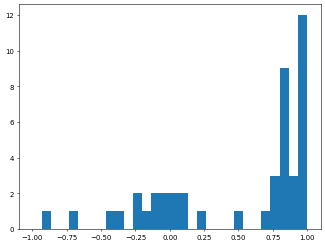

In [94]:
# fig,ax = plt.subplots(1)
idx_aux = np.random.randint(0,100,1)[0]
idx = corr_in_idx[in_samples[idx_aux]]
cov_out = network.model[len(network.model)-1].W.array @ cp.diag(var_s[in_samples[idx_aux]].array) @ network.model[len(network.model)-1].W.array.T
corr_out = (cp.diag(1/cp.sqrt(cp.diag(cov_out)))) @ cov_out @ (cp.diag(1/cp.sqrt(cp.diag(cov_out))))
# statsmodels.stats.moment_helpers.cov2corr(cuda.to_cpu(corr_out))
corr_out_arr = corr_out[np.tril(corr_out, -1) != 0]
# print(r[idx_aux])
# print(cuda.to_cpu(corr_out_arr).shape)
fig = plt.figure(dpi=50,constrained_layout=True)
ax = fig.add_subplot(111)
# plt.xlim([-0.012, -0.008])
# plt.ylim([-0.0135, -0.011])
x_axis = np.arange(-1, 1, 0.02)
# line1 = ax.plot(x_axis, histogram)
line1 = ax.hist(r[idx_aux], bins=30, range=(-1,1))
# line2 = ax.hist(cuda.to_cpu(corr_out_arr), bins=30, range=(-1,1))
# plt.plot(out_samples[:,0],out_samples[:,6])
# fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
# ax.axis('off')
plt.show()